## I am using LUNA16 competition dataset

Lung cancer is the leading cause of cancer-related death worldwide. Screening high risk individuals for lung cancer with low-dose CT scans is now being implemented in the United States and other countries are expected to follow soon. In CT lung cancer screening, many millions of CT scans will have to be analyzed, which is an enormous burden for radiologists. Therefore there is a lot of interest to develop computer algorithms to optimize screening.?

The upcoming high-profile?Coding4Cancer?challenge invites coders to create the best computer algorithm that can identify a person as having lung cancer based on one or multiple low-dose CT images.

To be able to solve the Coding4Cancer challenge, and detect lung cancer in an early stage, pulmonary nodules, the early manifestation of lung cancers, have to be located. Many Computer-aided detection (CAD) systems have already been proposed for this task. The LUNA16 challenge will focus on a large-scale evaluation of automatic nodule detection algorithms on the publicly available LIDC/IDRI dataset.

## Things to do!
### Monday
1. .mhd files (extract 3D image data) - done

### Tuesday
2. Extract 2D image slice based on the coordinates?
3. Preprocess data


### Day after + Thursday
4. Train a CNN
5. Validate using their evaluation
6. Uncertainty quantification



In [1]:
2428/(2428+15660.0)

0.13423264042459088

### Import necessary libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

import os
import glob

import SimpleITK as sitk

from PIL import Image

%matplotlib inline
from IPython.display import clear_output
pd.options.mode.chained_assignment = None

### Let us import annotations

In [3]:
annotations = pd.read_csv('../src/data/annotations.csv')
candidates = pd.read_csv('../src/data/candidates.csv')

In [30]:
annotations.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


In [31]:
candidates['class'].sum()

1351

In [32]:
len(annotations)

1186

### Candidates have two classes, one with nodules, one without

In [5]:
candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551065 entries, 0 to 551064
Data columns (total 5 columns):
seriesuid    551065 non-null object
coordX       551065 non-null float64
coordY       551065 non-null float64
coordZ       551065 non-null float64
class        551065 non-null int64
dtypes: float64(3), int64(1), object(1)
memory usage: 21.0+ MB


In [6]:
print len(candidates[candidates['class'] == 1])
print len(candidates[candidates['class'] == 0])

1351
549714


In [25]:
import multiprocessing
num_cores = multiprocessing.cpu_count()
print num_cores

4


### Classes are heaviliy unbalanced, hardly 0.2% percent are positive.

The best way to move forward will be to undersample the negative class and then augment the positive class heaviliy to balance out the samples.

#### Plan of attack:

1. Get an initial subsample of negative class and keep all of the positives such that we have a 80/20 class distribution

2. Create a training set such that we augment minority class heavilby rotating to get a 50/50 class distribution

In [8]:
class CTScan(object):
    def __init__(self, filename = None, coords = None):
        self.filename = filename
        self.coords = coords
        self.ds = None
        self.image = None

    def reset_coords(self, coords):
        self.coords = coords

    def read_mhd_image(self):
        path = glob.glob('../data/raw/*/'+ self.filename + '.mhd')
        self.ds = sitk.ReadImage(path[0])
        self.image = sitk.GetArrayFromImage(self.ds)

    def get_resolution(self):
        return self.ds.GetSpacing()

    def get_origin(self):
        return self.ds.GetOrigin()

    def get_ds(self):
        return self.ds

    def get_voxel_coords(self):
        origin = self.get_origin()
        resolution = self.get_resolution()
        voxel_coords = [np.absolute(self.coords[j]-origin[j])/resolution[j] \
            for j in range(len(self.coords))]
        return tuple(voxel_coords)
    
    def get_image(self):
        return self.image
    
    def get_subimage(self, width):
        self.read_mhd_image()
        x, y, z = self.get_voxel_coords()
        subImage = self.image[z, y-width/2:y+width/2, x-width/2:x+width/2]
        return subImage   
    
    def normalizePlanes(self, npzarray):
        maxHU = 400.
        minHU = -1000.
        npzarray = (npzarray - minHU) / (maxHU - minHU)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
        return npzarray
    
    def save_image(self, filename, width):
        image = self.get_subimage(width)
        image = self.normalizePlanes(image)
        Image.fromarray(image*255).convert('L').save(filename)
        

In [9]:
positives = candidates[candidates['class']==1].index  
negatives = candidates[candidates['class']==0].index

###  Check if my class works

In [10]:
scan = CTScan(np.asarray(candidates.iloc[negatives[600]])[0], \
              np.asarray(candidates.iloc[negatives[600]])[1:-1])
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()

/Users/nemo/anaconda/envs/kaggleShit/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


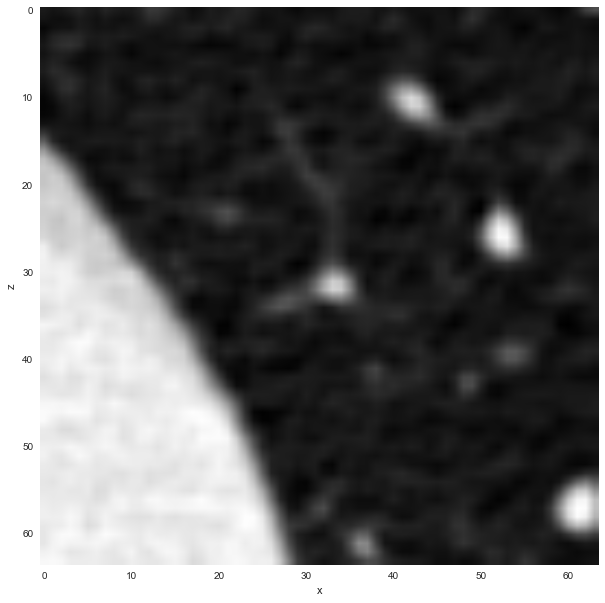

In [11]:
plt.figure(figsize = (10,10))
plt.imshow(image[z,y-65/2:y+65/2,x-65/2:x+65/2], cmap = 'gray')
#plt.scatter(x, y)
plt.grid('off')
plt.ylabel('z')
plt.xlabel('x')

### Try it on a test set you know works

In [12]:
filename = '1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208'
coords = (70.19, -140.93, 877.68)#[877.68, -140.93, 70.19]
scan = CTScan(filename, coords)
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()

/Users/nemo/anaconda/envs/kaggleShit/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


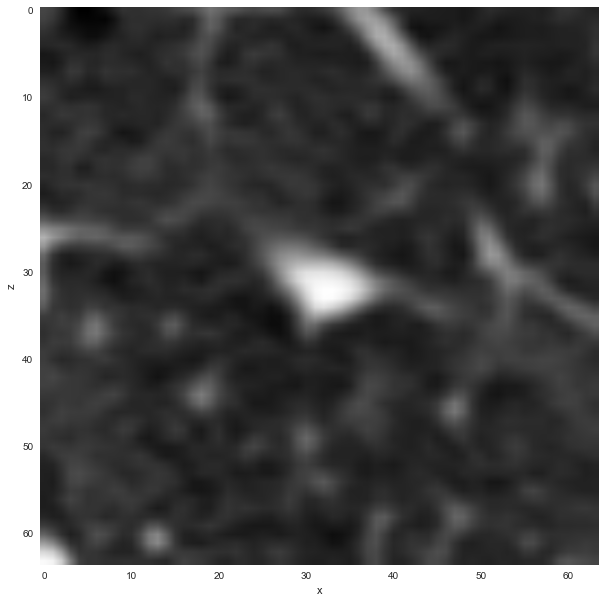

In [13]:
plt.figure(figsize = (10,10))
plt.imshow(image[z,y-65/2:y+65/2,x-65/2:x+65/2], cmap = 'gray')
#plt.scatter(x, y)
plt.grid('off')
plt.ylabel('z')
plt.xlabel('x')

###  Ok the class to get image data works

Next thing to do is to undersample negative class drastically. Since the number of positives in the data set of 551065 are 1351 and rest are negatives, I plan to make the dataset less skewed. Like a 70%/30% split.

In [14]:
positives

Int64Index([    13,     78,   1303,   3050,   3052,   3080,   3223,   3285,
              3287,   3289,
            ...
            545928, 546205, 546372, 546400, 547498, 548674, 550171, 550334,
            550810, 550906],
           dtype='int64', length=1351)

In [15]:
np.random.seed(42)
negIndexes = np.random.choice(negatives, len(positives)*5, replace = False)

In [16]:
candidatesDf = candidates.iloc[list(positives)+list(negIndexes)]

### Now split it into test train set 

In [17]:
from sklearn.cross_validation import train_test_split
X = candidatesDf.iloc[:,:-1]
y = candidatesDf.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

### Create a validation dataset

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

In [35]:
len(X_train)

5187

In [18]:
X_train.to_pickle('traindata')
X_test.to_pickle('testdata')
X_val.to_pickle('valdata')

In [36]:
def normalizePlanes(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

### Focus on training data

In [37]:
print 'number of positive cases are ' + str(y_train.sum())
print 'total set size is ' + str(len(y_train))
print 'percentage of positive cases are ' + str(y_train.sum()*1.0/len(y_train))

number of positive cases are 845
total set size is 5187
percentage of positive cases are 0.16290726817


### There are 845 positive cases out of 5187 cases in the training set. We will need to augment the positive dataset like mad. 

### Add new keys to X_train and y_train for augmented data

In [133]:
tempDf = X_train[y_train == 1]
tempDf = tempDf.set_index(X_train[y_train == 1].index + 1000000)
X_train_new = X_train.append(tempDf)
tempDf = tempDf.set_index(X_train[y_train == 1].index + 2000000)
X_train_new = X_train_new.append(tempDf)

ytemp = y_train.reindex(X_train[y_train == 1].index + 1000000)
ytemp.loc[:] = 1
y_train_new = y_train.append(ytemp)
ytemp = y_train.reindex(X_train[y_train == 1].index + 2000000)
ytemp.loc[:] = 1
y_train_new = y_train_new.append(ytemp)

print len(X_train_new), len(y_train_new)


6877 6877


In [131]:
ytemp.loc[:] = 1

### Preprocessing

In [87]:
from scipy.misc import imresize
from PIL import ImageEnhance

class PreProcessing(object):
    def __init__(self, image = None):
        self.image = image
    
    def subtract_mean(self):
        self.image = (self.image/255.0 - 0.25)*255
        return self.image
    
    def downsample_data(self):
        self.image = imresize(self.image, size = (40, 40), interp='bilinear', mode='L')
        return self.image
    
    def enhance_contrast(self):
        self.image = ImageEnhance.Contrast(self.image)
        return self.image
        

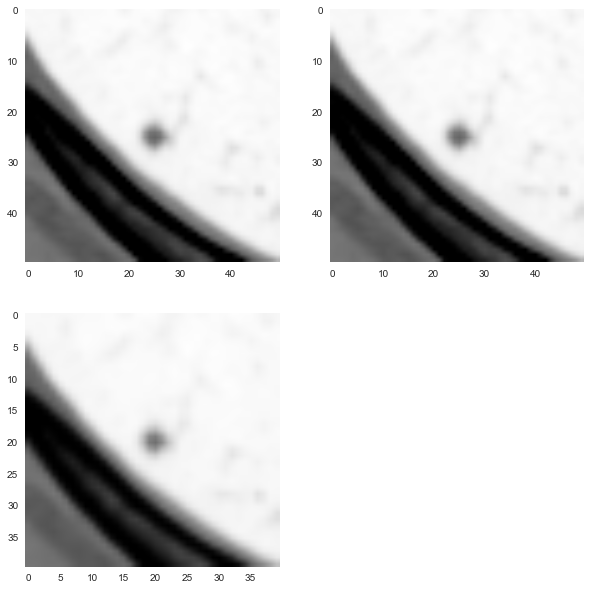

In [88]:
plt.figure(figsize = (10,10))
inp = imread(dirName + 'image_'+ str(30517) + '.tiff')
plt.subplot(221)
plt.imshow(inp)
plt.grid(False)

Pp = PreProcessing(inp)

inp2 = Pp.subtract_mean()
plt.subplot(222)
plt.imshow(inp2)
plt.grid(False)

#inp4 = Pp.enhance_contrast()
#plt.subplot(224)
#plt.imshow(inp4)
#plt.grid(False)

inp3 = Pp.downsample_data()
plt.subplot(223)
plt.imshow(inp3)
plt.grid(False)

#inp4 = Pp.enhance_contrast()
#plt.subplot(224)
#plt.imshow(inp4)
#plt.grid(False)

In [85]:
dirName

'../src/data/train/'

### Convnet stuff

In [26]:
import tensorflow as tf

In [27]:
tf.__version__

'0.12.1'

### Massaging data into form
Feeding data file by file is inefficient. So is loading all the data I have into memory

In [99]:
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes

In [220]:
train_filenames =\
X_train_new.index.to_series().apply(lambda x:\
                                    '../src/data/train/images_'+str(x)+'.jpg')
train_filenames.values

array(['../src/data/train/images_59270.jpg',
       '../src/data/train/images_150277.jpg',
       '../src/data/train/images_432208.jpg', ...,
       '../src/data/train/images_2352132.jpg',
       '../src/data/train/images_2188812.jpg',
       '../src/data/train/images_2459476.jpg'], dtype=object)

In [228]:
y_train_new.values.shape

(6877,)

In [184]:
train_images = ops.convert_to_tensor(train_filenames, dtype=dtypes.string)
train_labels =\
ops.convert_to_tensor(y_train_new.values.astype(int), dtype=dtypes.int64)

### Batch image data feeder to CNN

In [262]:
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes

import pandas as pandas

## Creates batches of images 
class Dataset(object):
    def __init__(self, X = None, y = None, filepath = None):
        self.X = X
        self.y = y
        self.image = None
        self.label = None
        self.filepath = filepath
    
    def get_filenames_labels(self):
        filenames =\
        self.X.index.to_series().apply(lambda x:\
                                       self.filepath + str(x) + '.jpg')
        images = ops.convert_to_tensor(filenames.values, dtype=dtypes.string)
        labels = ops.convert_to_tensor(self.y.values.astype(int), dtype=dtypes.int64)
        return images, labels
    
    def get_images_labels(self):
        return self.image, self.label
    
    def build_input_queues(self):
        '''
        Builds an input queue and defines how to load these images
        '''
        images, labels = self.get_filenames_labels()
        input_queue = tf.train.slice_input_producer([images, labels],\
                                      shuffle = False)

        file_content = tf.read_file(input_queue[0])
        self.image = tf.image.decode_jpeg(file_content, channels = 1)
        self.label = input_queue[1]
        return self.image, self.label 
    
    def create_image_batch(self, img_ht, img_width, num_channels, BATCH_SIZE):
        self.image.set_shape([img_ht, img_width, num_channels])
        image_batch, label_batch = tf.train.batch([self.image, self.label], \
                                                  batch_size = BATCH_SIZE)
        return image_batch, label_batch 
    

In [261]:
trainds = Dataset(X_train_new, y_train_new, '../src/data/train')
trainds.build_input_queues()
train_image_batch, train_label_batch = trainds.create_image_batch(50,50,1, 3)


AttributeError: 'module' object has no attribute 'next_batch'

In [257]:
train_label_batch

<tf.Tensor 'batch_2:1' shape=(3,) dtype=int64>

In [ ]:
with tf.Session() as sess:
    # initialize the variables
    sess.run(tf.initialize_all_variables())
    
    # initialize the queue threads to start to shovel data
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    print "from the train set:"
    for i in range(20):
        print sess.run(train_label_batch)
        
    #print "from the test set:"
    #for i in range(10):
    #    print sess.run(test_label_batch)
    
    # stop our queue threads and properly close the session
    coord.request_stop()
    coord.join(threads)
    sess.close()

###  Build a CNN model

In [259]:
x = tf.placeholder(tf.float32, shape=[None, 50,50])
y = tf.placeholder(tf.int64, shape=[None, 2])

In [ ]:
#https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/convolutional_network.py

# Parameters
learning_rate = 0.001
training_iters = 200000
batch_size = 128
display_step = 10

# Network Parameters
n_input =  50*50
n_classes = 2
dropout = 0.75 

# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 50, 50, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 64 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 64])),
    # 5x5 conv, 64 inputs, 96 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 64, 96])),
    # fully connected, 7*7*96 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*96, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([64])),
    'bc2': tf.Variable(tf.random_normal([96])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    
    
    # initialize the queue threads to start to shovel data
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,
                                       keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y,
                                                              keep_prob: 1.})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")

    # Calculate accuracy for 256 mnist test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: mnist.test.images[:256],
                                      y: mnist.test.labels[:256],
                                      keep_prob: 1.}))
Contact GitHub 

In [76]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], \
                          strides=[1, 2, 2, 1], padding='SAME')

###  First convolutional layer

We can now implement our first layer. It will consist of convolution, followed by max pooling. The convolution will compute 48 features for each 5x5 patch. Its weight tensor will have a shape of [5, 5, 1, 48]. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels. We will also have a bias vector with a component for each output channel.

In [91]:
W_conv1 = weight_variable([5, 5, 1, 48])
b_conv1 = bias_variable([48])

In [92]:
M = 40 # width
N = 40 # height
x_image = tf.reshape(x, [-1, M, N, 1])

We then convolve x_image with the weight tensor, add the bias, apply the ReLU function, and finally max pool. The max_pool_2x2 method will reduce the image size to M/2xN/2.

In [93]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

### Second convolutional layer

In order to build a deep network, we stack several layers of this type. The second layer will have 64 features for each 5x5 patch.

In [94]:
W_conv2 = weight_variable([5, 5, 48, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

### Densely connected layer

Now that the image size has been reduced to 7x7, we add a fully-connected layer with 1024 neurons to allow processing on the entire image. We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU.

In [95]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

### Dropout
To reduce overfitting, we will apply dropout before the readout layer. We create a placeholder for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. TensorFlow's tf.nn.dropout op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.1

In [96]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### Readout layer

Finally, we add a layer, just like for the one layer softmax regression above.

In [98]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

### Train and evaluate the model

How well does this model do? To train and evaluate it we will use code that is nearly identical to that for the simple one layer SoftMax network above.

The differences are that:

We will replace the steepest gradient descent optimizer with the more sophisticated ADAM optimizer.
We will include the additional parameter keep_prob in feed_dict to control the dropout rate.
We will add logging to every 100th iteration in the training process.
Feel free to go ahead and run this code, but it does 20,000 training iterations and may take a while (possibly up to half an hour), depending on your processor.

In [ ]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy =\
        accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy)
              train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict = \
                                       {x: mnist.test.images,\
                                        y_: mnist.test.labels,\
                                        keep_prob: 1.0}))